In [1]:
#Current working directort
import os
os.getcwd()

'd:\\Challenge Topic 3 DSC\\Asset Challenge'

In [3]:
import pandas as pd
import regex as re 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora, models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
from wordcloud import WordCloud
from nltk import FreqDist

In [4]:

data = pd.read_csv("D:/Challenge Topic 3 DSC/Asset Challenge/data.csv", encoding='latin-1')
alay_dict = pd.read_csv("D:/Challenge Topic 3 DSC/Asset Challenge/new_kamusalay.csv", names = ['original', 'replacement'], encoding='latin-1')
abusive_dict = pd.read_csv("D:/Challenge Topic 3 DSC/Asset Challenge/abusive.csv", encoding='latin-1')
pd.set_option('display.max_colwidth', None)
stopword_dict = pd.read_csv("D:/Challenge Topic 3 DSC/Asset Challenge/stopwordbahasa.csv", names = ['stopword'], encoding='latin-1')
data.head(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !',1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga',0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU',0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah',1,1,0,1,1,0,0,0,0,0,1,0
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x9f\x98\x84\xf0\x9f\x98\x84',1,1,0,1,0,0,0,0,1,0,1,0
6,deklarasi pilkada 2018 aman dan anti hoax warga dukuh sari jabon,0,0,0,0,0,0,0,0,0,0,0,0
7,Gue baru aja kelar re-watch Aldnoah Zero!!! paling kampret emang endingnya! 2 karakter utama cowonya kena friendzone bray! XD URL,0,1,0,0,0,0,0,0,0,0,0,0
8,"Nah admin belanja satu lagi port terbaik nak makan Ais Kepal Milo, Ais Kepal Horlicks atau Cendol Toping kaw kaw. ð??­; ; Doket mano tu ? Gerai Rojak Mertuaku - Taipan 2 (depan TWINS BABY &amp; ROMANTIKA / Bank Islam Senawang) ð???",0,0,0,0,0,0,0,0,0,0,0,0
9,USER Enak lg klo smbil ngewe',0,1,0,0,0,0,0,0,0,0,0,0


In [5]:
stopword_dict.head(10)

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
5,agaknya
6,agar
7,akan
8,akankah
9,akhir


In [6]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('RT',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('USER', ' ', text)
    text = re.sub('resource', ' ', text)
    text = re.sub('RESOURCE', ' ', text)
    text = re.sub('locator', ' ', text)
    text = re.sub('LOCATOR', ' ', text)
    text = re.sub('uniform', ' ', text)
    text = re.sub('UNIFORM', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:https?://|www\.)\S+\b', ' ', text, flags=re.IGNORECASE)
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text


In [7]:
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])
def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def remove_early_space(text):
    if text and text[0] == ' ':
        return text[1:]
    else:
        return text

def remove_emoticon_byte(text):
    text = text.replace("\\", " ")
    text = re.sub('x..', ' ', text)
    text = re.sub(' n ', ' ', text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

In [8]:
def bersihkan(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = remove_unnecessary_char(text)
    text = remove_stopword(text) # 5
    text = remove_early_space(text)
    text = remove_emoticon_byte(text)
    return text

def classify(hs):
    retval = ""
    if int(hs) == 1:
        retval = 'positive'
    else:
        retval = 'negative'
    return retval

data['Tweet_Bersih']=data['Tweet'].apply(bersihkan) #Apply fungsi bersihkan ke dalam kolom Tweet
data['hs_class'] = data['HS'].apply(classify)
data['abuse_class'] = data['Abusive'].apply(classify)
#data[['Tweet_Bersih', 'hs_class', 'abuse_class']].sample(10)

In [9]:

data['Weak_class'] = data['HS_Weak'].apply(classify)
data['Moderate_class'] = data['HS_Moderate'].apply(classify)
data['Strong_class'] = data['HS_Strong'].apply(classify)
hs_classification = data[['Tweet_Bersih', 'Weak_class', 'Moderate_class', 'Strong_class']]

In [10]:
hs_classification.head(11)

,Tweet_Bersih,Weak_class,Moderate_class,Strong_class
0,cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego,positive,negative,negative
1,telat tau edan sarap gue bergaul ciga ifla calis licew,negative,negative,negative
2,41 kadang berpikir percaya tuhan jatuh berkali kali kadang tuhan meninggalkan orang tuaku berencana berpisah kakakku memilih kristen anak ter,negative,negative,negative
3,ku tau matamu sipit,negative,negative,negative
4,kaum cebong kafir dongoknya dungu haha,negative,positive,negative
5,ya bani taplak kawan kawan,negative,positive,negative
6,deklarasi pilihan kepala daerah 2018 aman anti hoaks warga dukuh sari jabon,negative,negative,negative
7,gue selesai re watch aldnoah zero kampret 2 karakter utama cowoknya kena friendzone bro xd,negative,negative,negative
8,admin belanja po terbaik nak makan ais kepal milo ais kepal horlicks cendol toping kau kau doket gerai rozak me uaku taipan 2 kembar baby amp romantika bank islam senawang,negative,negative,negative
9,enak ngewe,negative,negative,negative


In [11]:
abusive_words = set(abusive_dict['ABUSIVE'].str.lower())

In [14]:
# Function to get the top abusive words for each classification
def get_top_abusive_words_by_classification(df, classification_column, text_column, abusive_words, top_n=20):
    result = {}
    positive_classifications = ['Weak_class', 'Moderate_class', 'Strong_class']
    for classification_value in df[classification_column].unique():
        subset = df[df[classification_column] == classification_value][text_column]
        
        # Combine all tweets into a single string
        combined_text = ' '.join(subset)

        # Tokenize the text
        tokens = word_tokenize(combined_text)

        # Filter out non-abusive words
        abusive_tokens = [word.lower() for word in tokens if word.lower() in abusive_words]

        # Calculate word frequencies for abusive words
        freq_dist = FreqDist(abusive_tokens)

        # Get the top abusive words and their frequencies
        top_abusive_words = freq_dist.most_common(top_n)

        result[classification_value] = top_abusive_words

    return result



In [16]:
# Get top abusive words for each HS classification
top_abusive_words_by_classification_weak = get_top_abusive_words_by_classification(
    hs_classification, 'Weak_class', 'Tweet_Bersih', abusive_words
)

# Display the results
for classification, top_abusive_words in top_abusive_words_by_classification_weak.items():
    print(f"Top abusive words in {classification} classification:")
    print(top_abusive_words)
    print()

Top abusive words in positive classification:
[('cebong', 237), ('komunis', 154), ('anjing', 142), ('kafir', 139), ('rezim', 124), ('goblok', 122), ('asing', 121), ('babi', 105), ('onta', 102), ('tolol', 100), ('tai', 100), ('bangsat', 99), ('bacot', 96), ('dungu', 94), ('bego', 75), ('banci', 71), ('bodoh', 69), ('kampret', 65), ('bajingan', 62), ('antek', 53)]

Top abusive words in negative classification:
[('asing', 617), ('komunis', 575), ('cebong', 313), ('rezim', 242), ('kafir', 235), ('antek', 218), ('tai', 177), ('sipit', 171), ('kontol', 168), ('anjing', 155), ('kampret', 148), ('bani', 142), ('memek', 141), ('ngentot', 140), ('monyet', 130), ('anjir', 130), ('onta', 130), ('cacat', 129), ('bodoh', 122), ('buta', 121)]



In [17]:
# Get top abusive words for each HS classification
top_abusive_words_by_classification_moderate = get_top_abusive_words_by_classification(
    hs_classification, 'Moderate_class', 'Tweet_Bersih', abusive_words
)

# Display the results
for classification, top_abusive_words in top_abusive_words_by_classification_moderate.items():
    print(f"Top abusive words in {classification} classification:")
    print(top_abusive_words)
    print()

Top abusive words in negative classification:
[('asing', 626), ('komunis', 509), ('rezim', 281), ('cebong', 265), ('kafir', 253), ('anjing', 247), ('tai', 232), ('onta', 187), ('kontol', 186), ('goblok', 178), ('sipit', 177), ('babi', 170), ('antek', 168), ('monyet', 167), ('bodoh', 165), ('ngentot', 157), ('anjir', 153), ('cacat', 151), ('memek', 147), ('bangsat', 127)]

Top abusive words in positive classification:
[('cebong', 285), ('komunis', 220), ('kafir', 121), ('asing', 112), ('bani', 110), ('kampret', 107), ('antek', 103), ('rezim', 85), ('dungu', 81), ('goblok', 52), ('anjing', 50), ('onta', 45), ('tai', 45), ('babi', 42), ('tolol', 40), ('bangsat', 30), ('bajingan', 30), ('keparat', 27), ('bodoh', 26), ('bejat', 25)]



In [19]:
# Get top abusive words for each HS classification
top_abusive_words_by_classification_strong = get_top_abusive_words_by_classification(
    hs_classification, 'Strong_class', 'Tweet_Bersih', abusive_words
)

# Display the results
for classification, top_abusive_words in top_abusive_words_by_classification_strong.items():
    print(f"Top abusive words in {classification} classification:")
    print(top_abusive_words)
    print()

Top abusive words in negative classification:
[('asing', 732), ('komunis', 627), ('cebong', 546), ('kafir', 367), ('rezim', 341), ('anjing', 291), ('tai', 275), ('antek', 259), ('onta', 229), ('goblok', 227), ('kampret', 211), ('babi', 204), ('kontol', 194), ('bodoh', 189), ('sipit', 185), ('dungu', 185), ('monyet', 177), ('bani', 170), ('ngentot', 158), ('anjir', 156)]

Top abusive words in positive classification:
[('komunis', 102), ('rezim', 25), ('antek', 12), ('babi', 8), ('kafir', 7), ('anjing', 6), ('asing', 6), ('bangsat', 4), ('cebong', 4), ('munafik', 4), ('onta', 3), ('rejim', 3), ('gila', 3), ('goblok', 3), ('bajingan', 3), ('dungu', 2), ('bodoh', 2), ('sampah', 2), ('kampret', 2), ('lgbt', 2)]



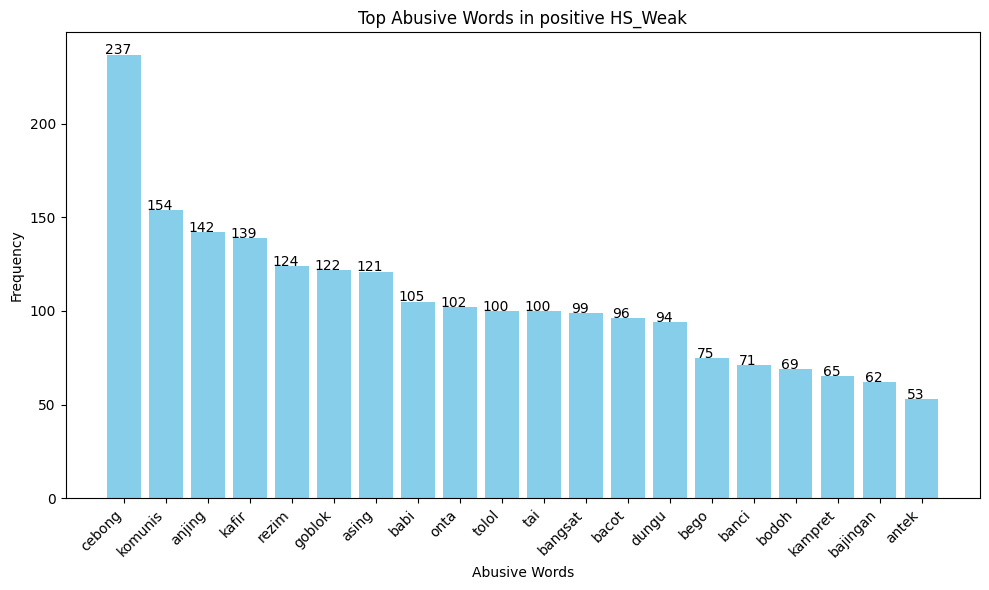

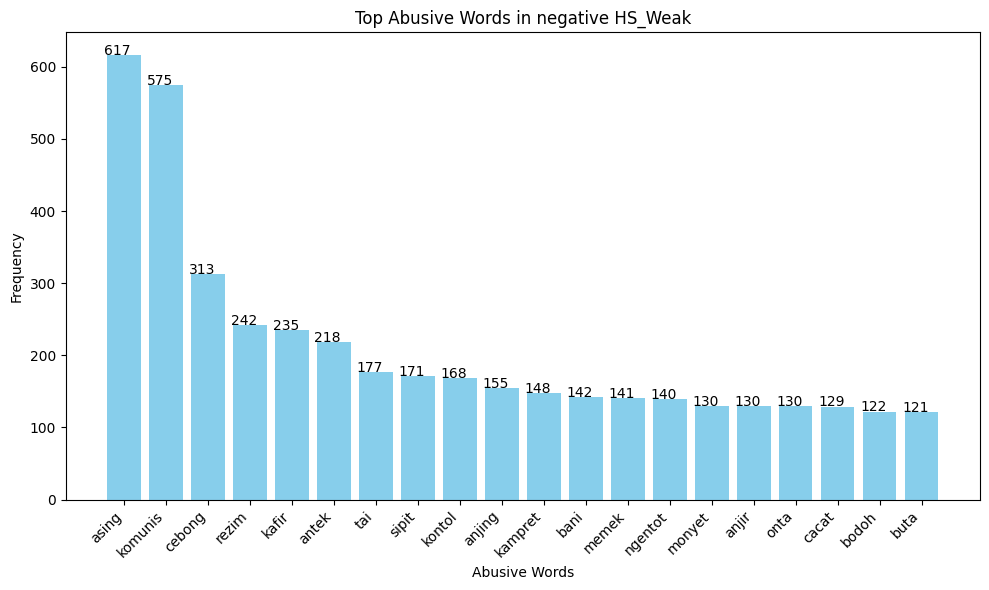

In [20]:
for classification, top_abusive_words in top_abusive_words_by_classification_weak.items():
    words, frequencies = zip(*top_abusive_words)
    
    plt.figure(figsize=(10, 6))
    bars= plt.bar(words, frequencies, color='skyblue')
    plt.title(f"Top Abusive Words in {classification} HS_Weak")
    plt.xlabel('Abusive Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Biar enak dibaca sikit

    for bar, frequency in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.1, str(frequency), ha='center')

    plt.tight_layout()
    plt.show()

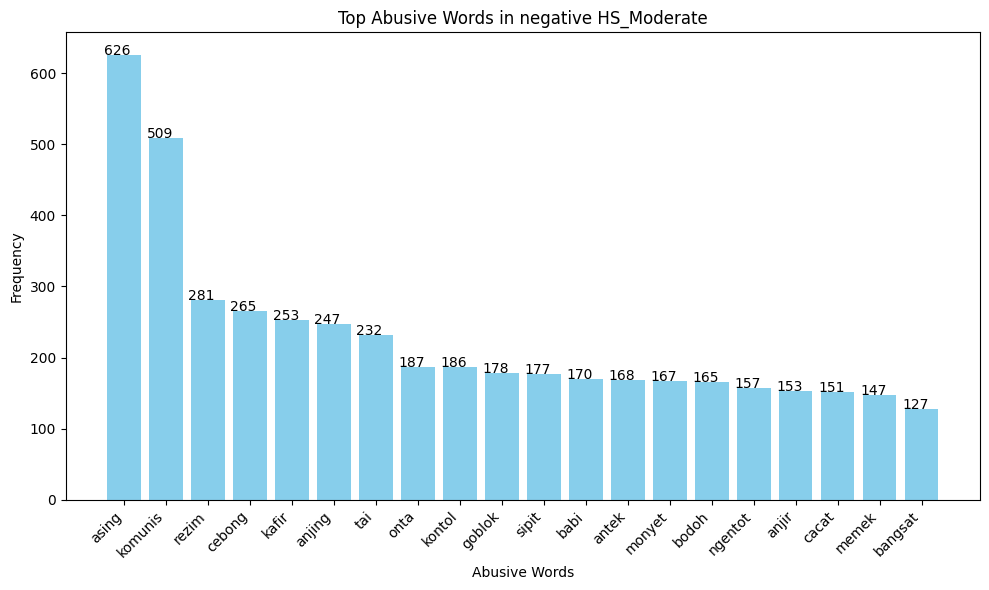

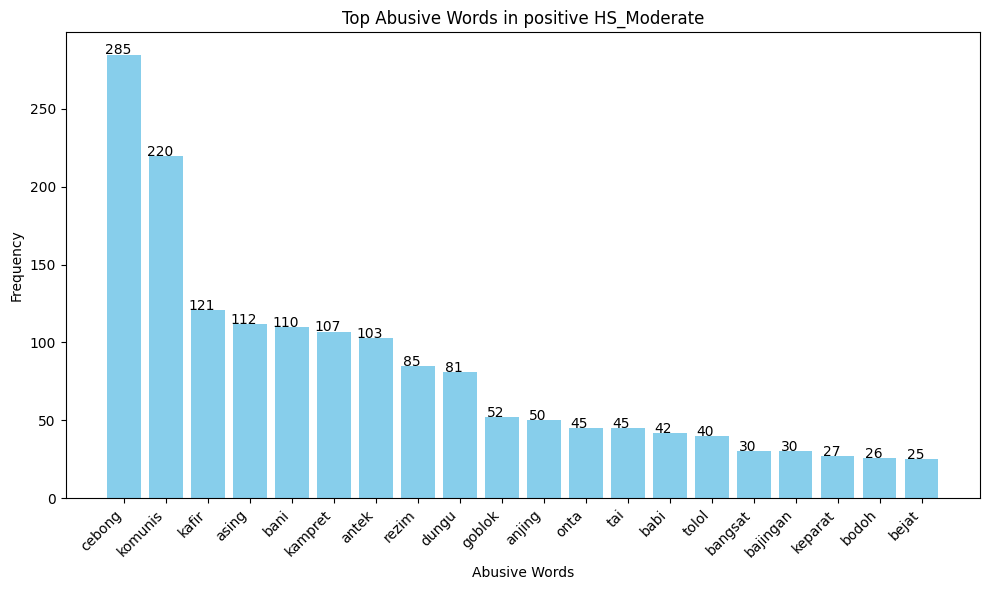

In [21]:
for classification, top_abusive_words in top_abusive_words_by_classification_moderate.items():
    words, frequencies = zip(*top_abusive_words)
    
    plt.figure(figsize=(10, 6))
    bars= plt.bar(words, frequencies, color='skyblue')
    plt.title(f"Top Abusive Words in {classification} HS_Moderate")
    plt.xlabel('Abusive Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Biar enak dibaca sikit

    for bar, frequency in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.1, str(frequency), ha='center')

    plt.tight_layout()
    plt.show()

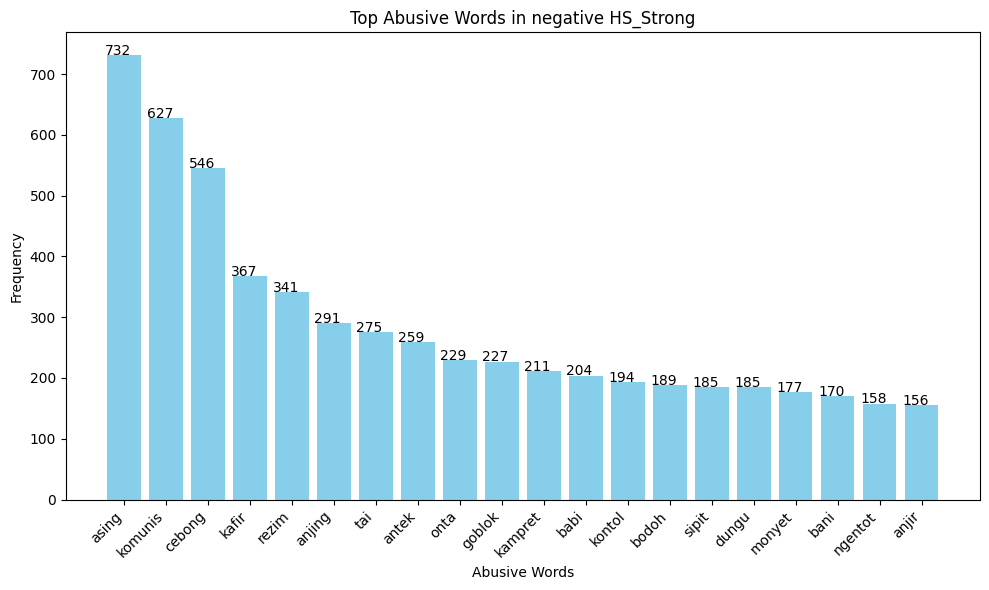

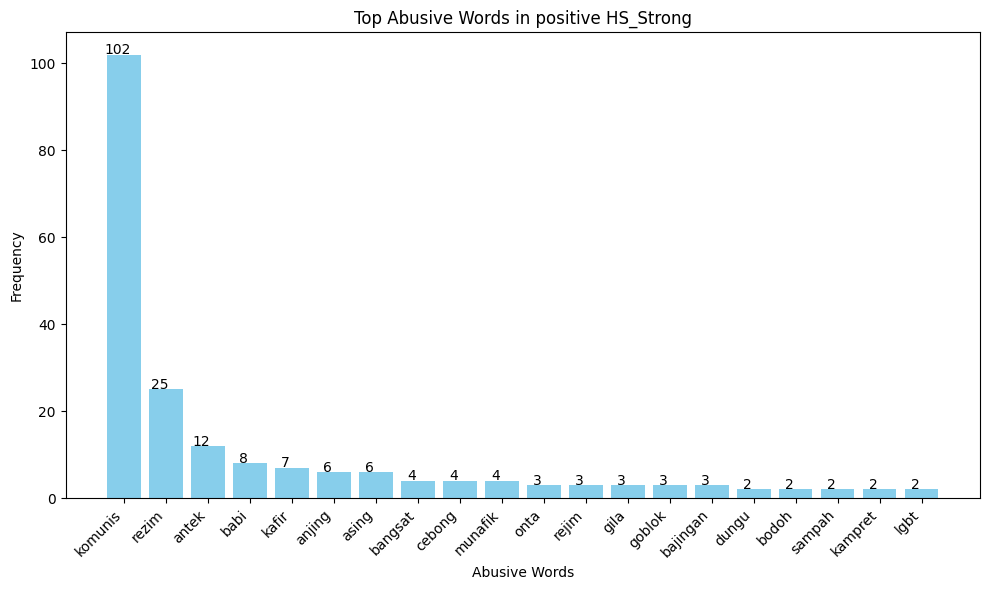

In [22]:
for classification, top_abusive_words in top_abusive_words_by_classification_strong.items():
    words, frequencies = zip(*top_abusive_words)
    
    plt.figure(figsize=(10, 6))
    bars= plt.bar(words, frequencies, color='skyblue')
    plt.title(f"Top Abusive Words in {classification} HS_Strong")
    plt.xlabel('Abusive Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Biar enak dibaca sikit

    for bar, frequency in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.1, str(frequency), ha='center')

    plt.tight_layout()
    plt.show()

In [59]:
def tokenize_text(text):
    return word_tokenize(text)

# Apply tokenization to each row in 'Tweet_Bersih'
hs_classification['tokenized_text'] = hs_classification['Tweet_Bersih'].apply(tokenize_text)


C:\Users\Smart Centre\AppData\Local\Temp\ipykernel_15656\3329717476.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hs_classification['tokenized_text'] = hs_classification['Tweet_Bersih'].apply(tokenize_text)


In [60]:
# Create a dictionary and a corpus for each HS category
dictionary_weak = corpora.Dictionary(hs_classification[hs_classification['Weak_class'] == 'positive']['tokenized_text'])
corpus_weak = [dictionary_weak.doc2bow(text) for text in hs_classification[hs_classification['Weak_class'] == 'positive']['tokenized_text']]

dictionary_moderate = corpora.Dictionary(hs_classification[hs_classification['Moderate_class'] == 'positive']['tokenized_text'])
corpus_moderate = [dictionary_moderate.doc2bow(text) for text in hs_classification[hs_classification['Moderate_class'] == 'positive']['tokenized_text']]

dictionary_strong = corpora.Dictionary(hs_classification[hs_classification['Strong_class'] == 'positive']['tokenized_text'])
corpus_strong = [dictionary_strong.doc2bow(text) for text in hs_classification[hs_classification['Strong_class'] == 'positive']['tokenized_text']]

In [61]:
# Apply LDA model to each HS category
lda_model_weak = models.LdaModel(corpus_weak, num_topics=3, id2word=dictionary_weak, passes=20)
lda_model_moderate = models.LdaModel(corpus_moderate, num_topics=3, id2word=dictionary_moderate, passes=20)
lda_model_strong = models.LdaModel(corpus_strong, num_topics=3, id2word=dictionary_strong, passes=20)


In [62]:
# Print topics for each HS category
print("Topics for Weak HS category:")
print(lda_model_weak.print_topics())

print("Topics for Moderate HS category:")
print(lda_model_moderate.print_topics())

print("Topics for Strong HS category:")
print(lda_model_strong.print_topics())

Topics for Weak HS category:
[(0, '0.020*"indonesia" + 0.013*"komunis" + 0.011*"prabowo" + 0.009*"ai" + 0.009*"rakyat" + 0.008*"orang" + 0.008*"pa" + 0.008*"gue" + 0.007*"jokowi" + 0.006*"islam"'), (1, '0.046*"presiden" + 0.030*"jokowi" + 0.027*"2019" + 0.024*"ganti" + 0.007*"nya" + 0.007*"yudhoyono" + 0.007*"bambang" + 0.007*"rakyat" + 0.007*"susilo" + 0.007*"ya"'), (2, '0.016*"sih" + 0.015*"cebong" + 0.014*"orang" + 0.014*"gue" + 0.014*"ya" + 0.013*"ahok" + 0.009*"banget" + 0.008*"a" + 0.008*"dasar" + 0.008*"goblok"')]
Topics for Moderate HS category:
[(0, '0.017*"islam" + 0.013*"orang" + 0.011*"cina" + 0.010*"indonesia" + 0.009*"korupsi" + 0.007*"buddha" + 0.007*"rezim" + 0.007*"rakyat" + 0.006*"komisi" + 0.006*"teroris"'), (1, '0.022*"cebong" + 0.012*"kafir" + 0.010*"allah" + 0.009*"islam" + 0.009*"dungu" + 0.008*"ya" + 0.008*"wa" + 0.008*"taala" + 0.008*"subhanahu" + 0.008*"presiden"'), (2, '0.033*"indonesia" + 0.024*"ai" + 0.020*"pa" + 0.020*"komunis" + 0.013*"cina" + 0.012*"asin

In [63]:
hsweak = lda_model_weak.print_topics()
hsmoderate = lda_model_moderate.print_topics()
hsstrong = lda_model_strong.print_topics()

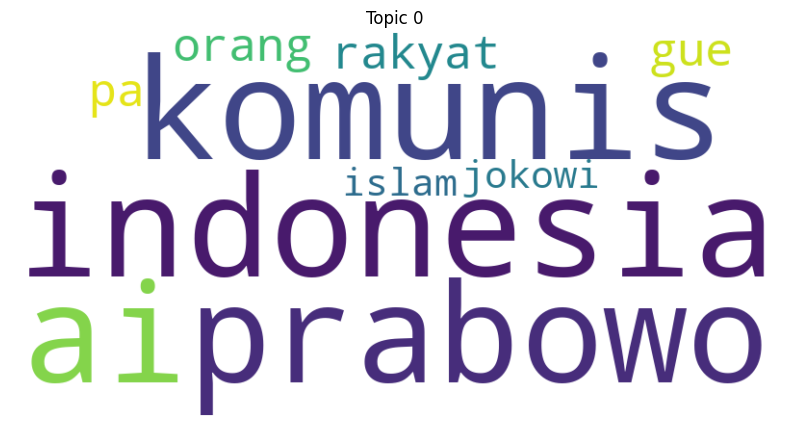

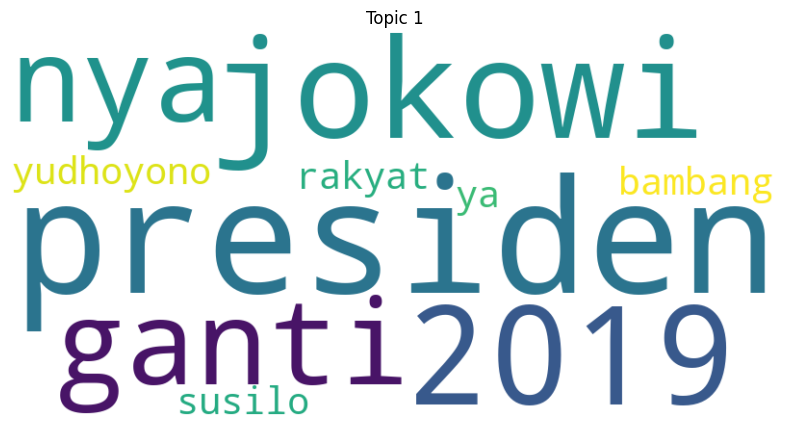

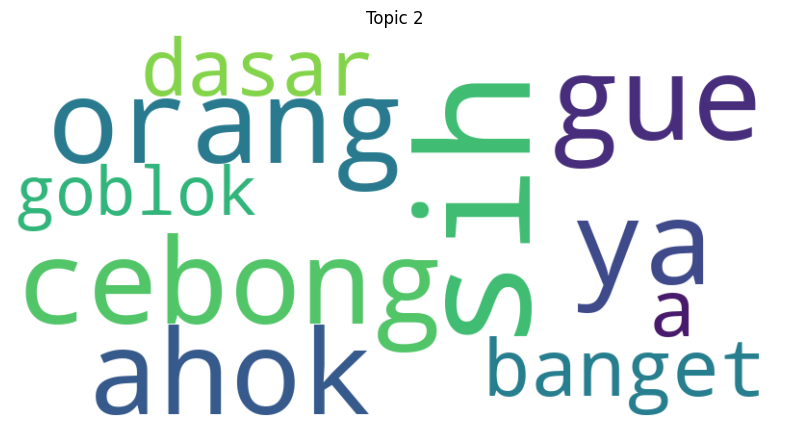

In [64]:
def visualize_word_clouds(topics):
    for i, topic in enumerate(topics):
        # Extracting words from the topic string
        topic_words = [word.split("*")[1].replace('"', '') for word in topic[1].split(" + ")]
        # Creating a dictionary for WordCloud
        wordcloud_dict = dict(zip(topic_words, [1] * len(topic_words)))  # Assigning a weight of 1 to each word
        # Generating WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)
        
        # Plotting WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {i}')
        plt.show()

# Visualize Word Clouds for Weak HS topics
visualize_word_clouds(hsweak)

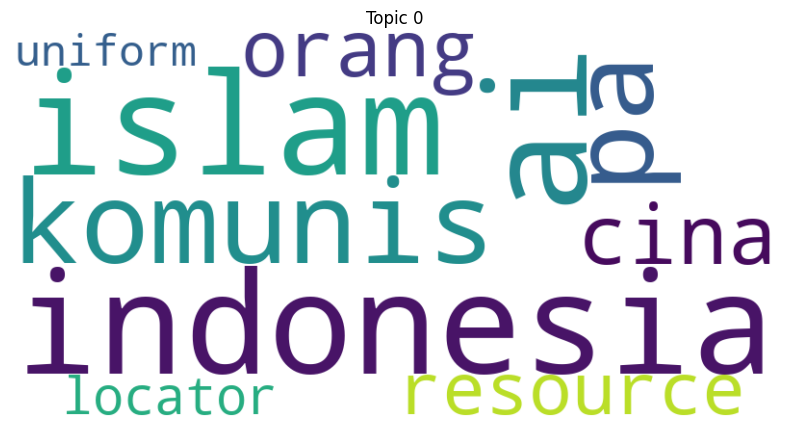

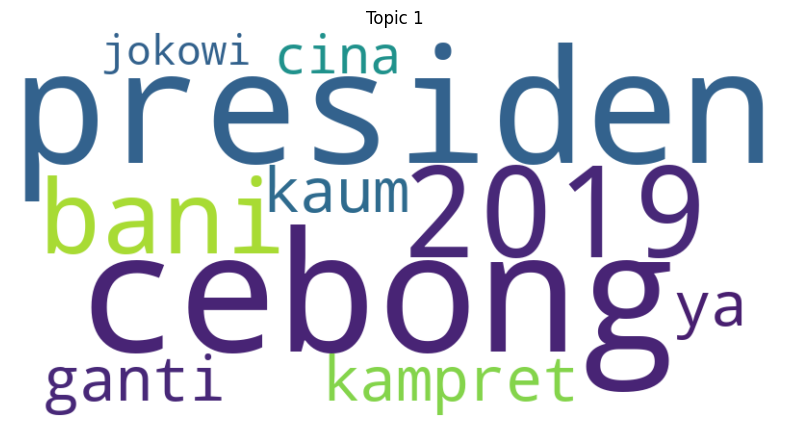

In [143]:
visualize_word_clouds(hsmoderate)

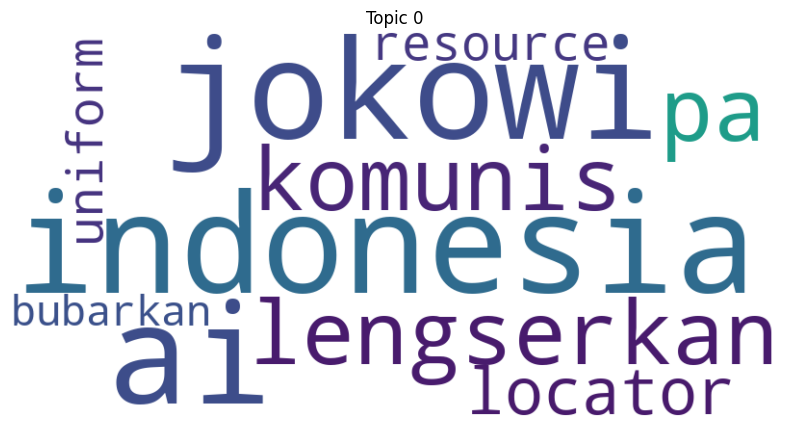

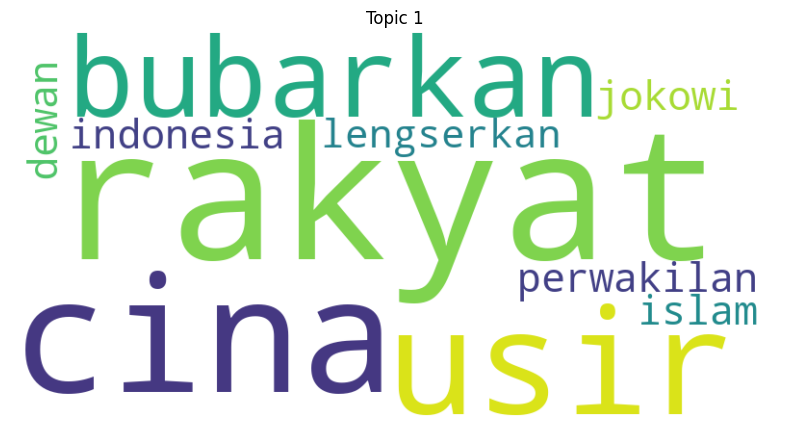

In [150]:
visualize_word_clouds(hsstrong)